In [16]:
import os #for accessing the file system of the system
import sys
import random

import numpy as np
import cv2 #computer vision lib for image processing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

seed = 2323; #seed values to create random values
random.seed = seed;
np.random.seed = seed;
tf.seed = seed;

In [17]:
#data generator class
class DataGen(keras.utils.Sequence):
    def __init__(self, train_ids, train_path, batch_size=10, image_size=128):
        self.ids = train_ids;
        self.path = train_path;
        self.batch_size = batch_size;
        self.image_size = image_size;
        self.on_epoch_end();
        
    def __load__(self, id_name):
        #defining path for the training data set
        image_path = os.path.join(self.path, "images", id_name);#polyp segmentation/images/id_name.jpg
        mask_path = os.path.join(self.path, "masks", id_name); #polyp segmenatation/masks/id_name.jpg
        
        # reading the image from dataset
        ## Reading Image
        image = cv2.imread(image_path, 1); #reading image to image vaiable
        image = cv2.resize(image, (self.image_size, self.image_size));# resizing input image to 128 * 128
        
        mask = cv2.imread(mask_path, 0); #mask image of same size with all zeros
        mask = cv2.resize(mask, (self.image_size ,self.image_size));# resizing mask to fit the 128 * 128 image
        mask = np.expand_dims(mask, axis=-1);
        #image normalisation
        image = image / 255.0;
        mask = mask / 255.0;
        
        return image, mask;
    
    def __getitem__(self, index): #index : batch no.
        
        if(index+1)*self.batch_size > len(self.ids): # redining last batch size
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size] #list of 10 image ids
        
        image = [] #collection of 10 images
        mask  = [] #collection of 10 masks
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name);
            image.append(_img);
            mask.append(_mask);
            
        image = np.array(image);
        mask  = np.array(mask);
        
        return image, mask; #return array of 10 images and 10 masks
    
    #for printing the statistics of the function
    def on_epoch_end(self):
        print("epoch completed");
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)));#length of the epoch as length of generation DataGen obj

In [111]:
#hyperparameter
image_size = 128;
train_path = "../segmentation of polyp/polyp segmentation/"; #address of the dataset
epochs = 3; #number of time we need to train dataset
batch_size = 10; #tarining batch size

#train path
train_ids = os.listdir(train_path + "/images")
#Validation Data Size
val_data_size = 10; #size of set of images used for the validation 

valid_ids = train_ids[:val_data_size]; # list of image ids used for validation of result 0 to 9
train_ids = train_ids[val_data_size:]; #list of image ids used for training dataset
#print(valid_ids, "\n\n");
print("training_size: ", len(train_ids), "validation_size: ", len(valid_ids))

#making generator object
gen = DataGen(train_ids, train_path, batch_size, image_size);
print("total epoch: ", len(gen))
#print(valid_ids)

training_size:  990 validation_size:  10
total epoch:  99


shape of the batch (10, 128, 128, 3) (10, 128, 128, 1)
Number of images in the batch:  10


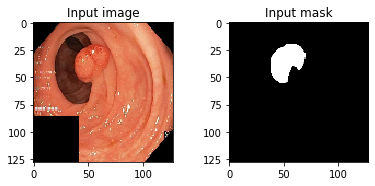

In [110]:
#Analysing sample of the dataset from data generator


#getting image_set data from dataset
x, y = gen.__getitem__(0); # self = gen and index = 0 each item is a set of 8 images
print("shape of the batch", x.shape, y.shape);
print("Number of images in the batch: ", len(x));

#display of the sample of the data zeroth image

fig = plt.figure();
fig.subplots_adjust(hspace=0.4, wspace=0.4); #reserving height above plot and space between plots
ax = fig.add_subplot(1, 2, 1); #figure of 1 row 2 columns and 1st image
x1 = (x[3]*255).astype(np.uint8);
x1 = cv2.cvtColor(x1, cv2.COLOR_BGR2RGB);
ax.imshow(x1);
plt.title("Input image");

ax = fig.add_subplot(1, 2, 2); #2nd image plot
ax.imshow(np.reshape(y[3], (image_size, image_size)), cmap="gray");
plt.title("Input mask");

In [20]:
#creating convolutional blocks

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x) # nearest interpolation
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [21]:
#unet model
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #pooling layer downsmaples 128*128 image to 64 * 64
    c2, p2 = down_block(p1, f[1]) #pooling layer downsmaples 128*128 image to 32 * 32
    c3, p3 = down_block(p2, f[2]) #pooling layer downsmaples 128*128 image to 16 * 16
    c4, p4 = down_block(p3, f[3]) #pooling layer downsmaples 128*128 image to 8 * 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #upsampling layer upsmaples 8 * 8 image to 16 * 16
    u2 = up_block(u1, c3, f[2]) #upsampling layer upsmaples 8 * 8 image to 32 * 32
    u3 = up_block(u2, c2, f[1]) #upsampling layer upsmaples 8 * 8 image to 64 * 64
    u4 = up_block(u3, c1, f[0]) #upsampling layer upsmaples 8 * 8 image to 128 * 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [22]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [23]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size);
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size);
print("total training batches: ", len(train_gen));
print("total validaton batches: ", len(valid_gen));
train_steps = len(train_ids)//batch_size;
valid_steps = len(valid_ids)//batch_size;

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=6);

total training batches:  99
total validaton batches:  1
Epoch 1/6
99/99 [==============================] - 2280s 23s/step - loss: 0.4122 - acc: 0.8341 - val_loss: 0.3887 - val_acc: 0.8120
Epoch 2/6
99/99 [==============================] - 2274s 23s/step - loss: 0.3530 - acc: 0.8403 - val_loss: 0.3968 - val_acc: 0.8120
Epoch 3/6
99/99 [==============================] - 2275s 23s/step - loss: 0.3363 - acc: 0.8443 - val_loss: 0.3572 - val_acc: 0.8344
Epoch 4/6
99/99 [==============================] - 2272s 23s/step - loss: 0.3290 - acc: 0.8507 - val_loss: 0.3719 - val_acc: 0.8279
Epoch 5/6
99/99 [==============================] - 2273s 23s/step - loss: 0.3265 - acc: 0.8493 - val_loss: 0.3745 - val_acc: 0.8286
Epoch 6/6
99/99 [==============================] - 2274s 23s/step - loss: 0.3204 - acc: 0.8558 - val_loss: 0.3506 - val_acc: 0.8329


In [106]:
## Save the Weights
model.save_weights("UNet polyp weight 2 epoch.h5")

## Dataset for prediction
p_image, p_mask = train_gen.__getitem__(0); #accessed as normalised bool

print("shape image: ", p_image.shape, "shape mask: ", p_mask.shape)

result_mask = model.predict(p_image); #collection of 10 masks

print("result_mask shape: ", result_mask.shape);

result_mask = result_mask > 0.30; #float probability to bool conversion

shape image:  (10, 128, 128, 3) shape mask:  (10, 128, 128, 1)
result_mask shape:  (10, 128, 128, 1)


Text(0.5, 1.0, 'Predicted mask')

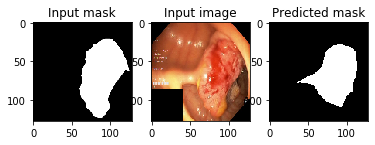

In [107]:
fig1 = plt.figure()
fig.subplots_adjust(hspace=.4, wspace=.6)
i = 2;
my_plot = fig1.add_subplot(1, 3, 1)
plt.title("Input mask")
my_plot.imshow(np.reshape(p_mask[i]*255, (image_size, image_size)), cmap="gray")

my_plot = fig1.add_subplot(1, 3, 2);
p_image = p_image[i][:,:,::-1]
my_plot.imshow(p_image);
plt.title("Input image")

my_plot = fig1.add_subplot(1, 3, 3)
my_plot.imshow(np.reshape(result_mask[i]*255, (image_size, image_size)), cmap="gray")
plt.title("Predicted mask")